# E-HGV Experiments

This notebook runs the experiments that we use in the paper 'Exploring charging infrastructure requirements for electric heavy-goods vehicles with agent-based modelling'

The first half runs the experriments. This takes some time though, so the results are cached to disk (if they've not already been saved) and then the second part analyses these results

## Import modules

In [1]:
import os
import scipy
import itertools
import multiprocessing
import pickle
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

import pynetlogo
import ipyparallel as ipp
from ipyparallel import Client

from tqdm import tqdm


## Define the problem

This defines the parameters used in the experiments

In [2]:
_problem = {

    "names": [
        "soc-threshold-low",
        "soc-threshold-high",
        "num-ultra-fast-chargers",
        "num-fast-chargers",
        "num-slow-chargers",
        "ratio-large-vehicle",
        #"arrivals-file"
        
    ],
    "bounds": [
        [0, 100],
        [0, 100],
        [0, 5],
        [0, 10],
        [0, 15],
        [0.1, 0.9],
        #[ ]
    ],
}

assert len(_problem['names']) == len(_problem['bounds'])

_problem["num_vars"] = len(_problem["names"])

Define the number of times we will re-run each scenario

In [3]:
_n = 800

The values that we want to report from the experiments

In [4]:
_report_vars = ["amount-of-time-vehicles-queuing",
                "number-of-trucks-queuing",
                "average-time-in-queue",
               "amount-of-time-charging-not-break",
                "total-trucks-charging-not-break",
                "average-time-charging-not-break",
               "amount-of-time-extra-charging",
                "total-vehicles-extra-charging",
                "average-extra-time-on-chargers"]

Number of iterations to run the model for (one tick is one second)

In [5]:
_model_run_time = 1440  # 1 days

The model to use. I couldn't work out how to pass the name of the arrivals file as a parameter, so it is hard-coded in the model file. We will run the Day 3 (wednesday) model first, then repeat a few steps to run the Sunday (day 0) model.

In [6]:
_netlogo_model_file = "ehgv_update_model-arrivals-v14-day3.nlogo"

## Define the experiments

Need to set values for each of the parameters that define the `problem`.

Use a class for flexibility (and I think it's neater).

In [7]:
class Experiment:

    # Class-level variable to store the problem definition and number of repetitions
    problem = _problem
    n = _n
    report_vars = _report_vars
    model_run_time = _model_run_time
    netlogo_model_file = _netlogo_model_file

    def __init__(self, experiment_number, experiment_name, parameter_values):
        """
        Experiment constructor
        :param experiment_number: An arbitrary experiment number
        :param experiment_name:  An arbitrary experiment name
        :param parameter_values: The values of the parameters for the experiment (as defined
        by the 'problem' class variable)
        """
        self.name = experiment_name
        self.number = experiment_number
        # The parameter values become a huge array, repeated n times. But it is also useful
        # to keep the original values
        self.parameter_values = parameter_values  # Keep the original values
        self.parameter_array = np.array([parameter_values] * Experiment.n)  # The long array needed to run experiments
        # An internal variable stores the results of this experiment
        self.results = None

    def store_results(self, results_series):
        """
        Store the results of the experiment
        :param results_series: a results series that comes out of the simulation function (defined below)
        """
        params_df = pd.DataFrame(self.parameter_array)
        params_df.columns = Experiment.problem["names"]
        results_df = pd.concat([params_df, results_series], axis=1)
        results_df = results_df.round(
            {"num-ultra-fast-chargers":0,
             "num-fast-chargers":0,
             "num-slow-chargers":0,
             })
        self.results = results_df

# These six experiments are for the Wednesday model
experiments = [
    Experiment(1, "Wed-Baseline0", [20, 80, 2, 5, 4, 0.8]),
    Experiment(2, "Wed-Scenario2", [20, 80, 2, 8, 4, 0.8]),
    Experiment(3, "Wed-Scenario3", [20, 80, 3, 5, 4, 0.8]),
    Experiment(4, "Wed-Scenario4", [20, 80, 2, 2, 4, 0.8]),
    Experiment(5, "Wed-Scenario5", [20, 80, 1, 5, 4, 0.8]),
    Experiment(6, "Wed-Scenario6", [20, 80, 2, 5, 4, 0.2]),
]

# Define new experiments for the Sunday (these will be run after all the Wednesday stuff)
experiments_sun = [
    Experiment(7,  "Sun-Baseline0", [20, 80, 2, 5, 4, 0.8]),
    Experiment(8,  "Sun-Scenario2", [20, 80, 2, 8, 4, 0.8]),
    Experiment(9,  "Sun-Scenario3", [20, 80, 3, 5, 4, 0.8]),
    Experiment(10, "Sun-Scenario4", [20, 80, 2, 2, 4, 0.8]),
    Experiment(11, "Sun-Scenario5", [20, 80, 1, 5, 4, 0.8]),
    Experiment(12, "Sun-Scenario6", [20, 80, 2, 5, 4, 0.2]),
]

**Stop here if you don't want to run the experiments (maybe you ran them earlier and they have been pickled).**

If you have previously run both Wednesday and Sunday experiments then just skip down to the "Load the experiment results" section.

If you want to run the Sunday experiments, run 'Prepare the simulation engine' but then skip down to the "Run the Sunday model" section. I'm not sure if you can run the Wednesday experiments and then the sunday experiemnts in one go (I was getting a netlogo error and didn't debug it properly, but it may be something to do with setting up the environment for one .nlogo model and then trying to load in a different one).

## Prepare the simulation engine

Get things read to run the experiments.

In [8]:
num_cores = multiprocessing.cpu_count() - 1  # Prevents too much swapping if 1 core left free?
print(f"Running on {num_cores} cores")
cluster = ipp.Cluster(n=num_cores)

Running on 11 cores


In [9]:
cluster.start_cluster_sync();

Starting 11 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


In [10]:
rc = cluster.connect_client_sync()
rc.wait_for_engines(num_cores)

  0%|          | 0/11 [00:00<?, ?engine/s]

In [11]:
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [12]:
direct_view = rc[:]

Broadcast some variables to the clusters

In [13]:
direct_view.push(dict(cwd=os.getcwd()), block=True)
direct_view.push({'Experiment': Experiment}, block=True)
#direct_view.push(dict(problem=Experiment.problem), block=True)

[None, None, None, None, None, None, None, None, None, None, None]

Define a function to run the simulations

In [14]:
def simulation(experiment_parameter_array ):
    """
    Run the NetLogo model with the given experiment definition
    :param experiment_parameter_array:  The parameter array of an experiment object
    (i.e. experiment.parameter_array)
    :param _Experiment: The Experiment class (this is needed because when this function
    is called as part of a paralell thread cluster it doesn't have access to the Experiment
    :return: The results as a pandas Series
    """

    # Set the input parameters
    for i, name in enumerate(Experiment.problem["names"]):
        # Run a netlogo commend to set the values of each of the parameters
        # Needs quote characters if it is a string.
        command = None
        if isinstance(experiment_parameter_array[i], str):
            command = 'set {0} "{1}"'.format(name, experiment_parameter_array[i])
        else:
            command = 'set {0} {1}'.format(name, experiment_parameter_array[i])
        netlogo.command(command)
#         if name == "random-seed":
#             # The NetLogo random seed requires a different syntax
#             netlogo.command("random-seed {}".format(experiment[i]))
#         else:
            # Otherwise, assume the input parameters are global variables

    netlogo.command("setup")

    counts = netlogo.repeat_report(Experiment.report_vars, Experiment.model_run_time)

    results = pd.Series(
        [counts[var].mean() for var in Experiment.report_vars],
        index=Experiment.report_vars
        #index=["Avg. waiting time", "Avg. charging time","Avg. charger utilization",
            #"Avg. energy consumption", "Avg. proportion unserved vehicles"],
    )

    return results

## Run the experiments


Load the NetLogo model onto each of the nodes

In [15]:

%%px
import os
import pynetlogo
import pandas as pd

cwd = os.getcwd()
os.chdir(cwd)

netlogo = pynetlogo.NetLogoLink(gui=False)
netlogo.load_model(Experiment.netlogo_model_file)
#netlogo.load_model(_netlogo_model_file)  # (Can't get this from the Experiment class directly)

%px:   0%|          | 0/11 [00:00<?, ?tasks/s]

The next chunk actually runs the experiment. This will probably take some time

In [16]:
lview = rc.load_balanced_view()

for experiment in tqdm(experiments):
  # Pass the parameter array to the simulation function.
    results = pd.DataFrame(
      lview.map_sync(simulation,
                     experiment.parameter_array,
                     ))
    experiment.store_results(results)

100%|█████████████████████████████████████████████| 6/6 [09:10<00:00, 91.78s/it]


In [19]:
# Look at some results for example
experiments[0].results

,soc-threshold-low,soc-threshold-high,num-ultra-fast-chargers,num-fast-chargers,num-slow-chargers,ratio-large-vehicle,amount-of-time-vehicles-queuing,number-of-trucks-queuing,average-time-in-queue,amount-of-time-charging-not-break,total-trucks-charging-not-break,average-time-charging-not-break,amount-of-time-extra-charging,total-vehicles-extra-charging,average-extra-time-on-chargers
0,20.0,80.0,2.0,5.0,4.0,0.8,589.891048,47.145732,9.061041,247.972935,14.731437,12.022915,701.576683,29.736988,18.991353
1,20.0,80.0,2.0,5.0,4.0,0.8,544.677307,44.154754,8.935843,229.829979,12.274809,13.228300,759.671756,25.764053,23.589091
2,20.0,80.0,2.0,5.0,4.0,0.8,645.010409,44.900763,9.899799,248.972935,12.586398,13.529577,768.343511,29.374740,20.514087
3,20.0,80.0,2.0,5.0,4.0,0.8,592.138099,49.269951,7.874885,264.507287,16.337266,10.878300,793.682859,27.597502,22.673657
4,20.0,80.0,2.0,5.0,4.0,0.8,647.057599,45.790423,9.631339,247.544761,12.405274,14.414261,847.959056,32.238029,21.554768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,20.0,80.0,2.0,5.0,4.0,0.8,719.691881,48.450382,10.551589,350.406662,19.002082,14.119396,766.177654,25.846634,23.950930
796,20.0,80.0,2.0,5.0,4.0,0.8,599.338654,45.836225,9.433935,215.760583,12.396253,10.862665,856.898681,32.086745,22.519327
797,20.0,80.0,2.0,5.0,4.0,0.8,661.270645,52.998612,8.390743,322.241499,16.526718,15.033248,816.744622,30.081888,21.301402
798,20.0,80.0,2.0,5.0,4.0,0.8,583.019431,43.770298,9.299847,266.116586,14.936155,12.831943,872.170715,28.800833,24.369195


 Save the results to disk

In [20]:
# Pickling (saving to file)
for experiment in experiments:
    with open(f'pickles/exp-{experiment.number}-{experiment.name}.pkl', 'wb') as file:
        pickle.dump(experiment, file)

## Run the Sunday model

Now repeat a few of the previous steps to run the Sunday (day 0) model. It isn't possible to do this at the same time as the previous model because I wasn't able to pass the input arrivals file as a parameter so we have two different netlogo models (that should be identical except for the name of the arrivals file).

In [21]:
# Set the model file to the Sunday model and push it to the clusters
Experiment.netlogo_model_file = "ehgv_update_model-arrivals-v14-day0.nlogo"
direct_view.push({'Experiment': Experiment}, block=True)

[None, None, None, None, None, None, None, None, None, None, None]

Need a new parallel chunk for the new model

In [22]:
%%px
import os
import pynetlogo
import pandas as pd

cwd=os.getcwd()
os.chdir(cwd)

netlogo = pynetlogo.NetLogoLink(gui=False)
netlogo.load_model(Experiment.netlogo_model_file)
#netlogo.load_model(_netlogo_model_file)  # (Can't get this from the Experiment class directly)

%px:   0%|          | 0/11 [00:00<?, ?tasks/s]

In [23]:
lview = rc.load_balanced_view()  # (Not sure this is necessary to do again)

for experiment in tqdm(experiments_sun):
    results = pd.DataFrame(
        lview.map_sync(simulation,
                       experiment.parameter_array,
                       ))
    experiment.store_results(results)

100%|█████████████████████████████████████████████| 6/6 [06:17<00:00, 62.88s/it]


In [24]:
for experiment in experiments_sun:
    with open(f'pickles/exp-{experiment.number}-{experiment.name}.pkl', 'wb') as file:
        pickle.dump(experiment, file)

## Load the experiment results (for Wednesday and Sunday)

These were calculated above and then cached. NOte that the `experiments` array will contain `Experiment` objects that defined the different scenarios. We need those so that we can work out what the pickled files are called, but they wont have any results in them. So we make a new list (`experiment_results`) and load the pickled experiments into that.

In [25]:
experiment_results_wed = []
for experiment in experiments:
    with open(f'pickles/exp-{experiment.number}-{experiment.name}.pkl', 'rb') as file:
        experiment_results_wed.append(pickle.load(file))

In [26]:
experiment_results_sun = []
for experiment in experiments_sun:
    with open(f'pickles/exp-{experiment.number}-{experiment.name}.pkl', 'rb') as file:
        experiment_results_sun.append(pickle.load(file))

In [27]:
# Sanity check. CHeck that the arrays have the right number of experiments in them and
# the results of experiments are the right shape
for x in [experiment_results_wed, experiment_results_sun]:
    assert len(x) == len(experiments)
    for y in x:
        assert y.results.shape == \
               (Experiment.n, (len(Experiment.report_vars) + len(Experiment.problem['names'])))

Look at some results as an example.

In [28]:
experiment_results_wed[5].results

,soc-threshold-low,soc-threshold-high,num-ultra-fast-chargers,num-fast-chargers,num-slow-chargers,ratio-large-vehicle,amount-of-time-vehicles-queuing,number-of-trucks-queuing,average-time-in-queue,amount-of-time-charging-not-break,total-trucks-charging-not-break,average-time-charging-not-break,amount-of-time-extra-charging,total-vehicles-extra-charging,average-extra-time-on-chargers
0,20.0,80.0,2.0,5.0,4.0,0.2,508.556558,44.961832,7.823567,192.257460,14.952117,7.979785,1166.337266,40.217904,23.261388
1,20.0,80.0,2.0,5.0,4.0,0.2,586.596808,46.225538,8.624101,142.387231,11.055517,9.084990,1104.174185,42.866759,21.595829
2,20.0,80.0,2.0,5.0,4.0,0.2,594.570437,45.885496,8.900069,124.229702,10.931992,8.740125,1176.021513,43.024289,22.809355
3,20.0,80.0,2.0,5.0,4.0,0.2,685.795975,48.299792,10.299341,146.981957,11.040250,9.805774,1262.870923,42.718945,24.905878
4,20.0,80.0,2.0,5.0,4.0,0.2,523.332408,46.251908,8.326447,165.541985,13.648855,8.675552,1029.522554,40.553088,19.936072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,20.0,80.0,2.0,5.0,4.0,0.2,615.809160,45.384455,9.487988,150.707148,10.836919,11.518827,1092.291464,41.026371,21.997620
796,20.0,80.0,2.0,5.0,4.0,0.2,600.466343,42.028452,9.999542,166.068702,12.942401,9.687772,1105.090215,40.117280,23.391811
797,20.0,80.0,2.0,5.0,4.0,0.2,582.755725,46.057599,8.389091,161.447606,13.453158,9.310361,1168.517002,43.324080,23.169285
798,20.0,80.0,2.0,5.0,4.0,0.2,585.112422,43.363636,10.262241,211.865371,15.221374,9.786266,1157.539209,40.043026,23.212262


## Analyse the results

Produce graphs for the paper. The following functions and parameters are useful.

In [29]:
def compute_x_y_lims(experiments, param_name):
    """
    Compute the global x-min, x-max, and y-max for the given parameter across all experiments.

    Parameters:
        experiments (list): List of experiment objects.
        param_name (str): The name of the parameter to evaluate.

    Returns:
        tuple: (global_x_min, global_x_max, global_y_max)
    """
    # Extract all the data for the given parameter across experiments
    all_data = [experiment.results[param_name] for experiment in experiments]

    # Find the global min and max for the x-axis
    global_x_min = min([min(data) for data in all_data])
    global_x_max = max([max(data) for data in all_data])

    # Compute the global y-max by finding the largest frequency count (histogram bin height)
    global_y_max = 0
    for data in all_data:
        hist_counts, _ = np.histogram(data)  # Use np.histogram to avoid plotting
        global_y_max = max(global_y_max, hist_counts.max())

    # Return the global x-min, x-max, and y-max as a tuple
    return global_x_min, global_x_max, global_y_max

In [30]:
# Plotting function for a list of experiments
def plot_experiment_parameters(experiments, report_vars, ylim=150, bins=20, num_cols=3,
                               plot_mean=False, title=None, filename=None):
    """
    Plot histograms for all parameters across multiple experiments on the same charts.

    Parameters:
        experiments (list): List of experiment objects whose parameters you want to visualize.
        report_vars (list): List of parameter names to plot.
        ylim (int): Y-axis limit for the histograms (default: 120).
        bins (int): Number of bins to use for histograms (default: 20).
        num_cols (int): Number of columns to use for the subplots (default: 3).
        plot_mean (bool): Whether to plot the mean value of each parameter (default: False).
        title (str): Optional title for the entire figure (default: None).
        filename (bool): Optional filename to save the plot as a PDF (default: None).
    """
    # Calculate good number of rows and columns for a square layout
    #num_cols = math.ceil(math.sqrt(len(report_vars)))  # A square-like layout
    #num_rows = math.ceil(len(report_vars) / num_cols)  # Ensure enough rows for all parameters
    # Always assume 3 columns and adjust rows accoddingly
    num_rows = math.ceil(len(report_vars) / num_cols)  # Ensure enough rows for all parameters

    # Dynamically adjust the figure height based on the number of rows
    fig_height = num_rows * 5  # Each row will be 5 units tall, you can adjust this

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, fig_height))
    axes = axs.flatten()
    
    # Define captions for each subplot
    captions = [f"({chr(97 + i)})" for i in range(len(report_vars))]  # Generates (a), (b), (c), ...


    # Loop through all parameters
    for i, param_name in enumerate(report_vars):
        # Loop through each experiment and plot the histogram for the current parameter
        for experiment in experiments:
            data = experiment.results[param_name]
            axes[i].hist(x=data, bins=bins, alpha=0.5, label=experiment.name,)

            # Add a mean line for each experiment?
            if plot_mean:
                mean_value = np.mean(data)
                axes[i].axvline(mean_value, linestyle='dashed', linewidth=2,
                                label=f'{experiment.name} Mean: {mean_value:.2f}')

        # Set title and y-axis limits
        axes[i].set_title(f'{param_name}')
        axes[i].set_ylim([0, ylim])
        
        # Add caption below each subplot
        axes[i].set_xlabel(captions[i], fontsize=15, labelpad=10)  # Adjust labelpad as needed



        # Add a legend to identify experiments
        axes[i].legend()

    # Add a main title to the entire figure
    if title is not None:
        plt.suptitle(f"{title}", fontsize=22)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlapping with the title

    # Optionally save the file
    if filename is not None:
        plt.savefig(f"figs/{filename}", format='pdf')
    plt.show()


### Box plot

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Plotting function for a list of experiments (boxplot version with custom x-axis categories)
def boxplot_experiment_parameters(experiments, report_vars, categories, num_cols = 3, 
                                  plot_mean=True, title=None, filename=None, ):
    """
    Plot boxplots for all parameters across multiple experiments on the same charts.

    Parameters:
        experiments (list): List of experiment objects whose parameters you want to visualize.
        report_vars (list): List of parameter names to plot.
        num_cols (int): Number of columns to use for the subplots (default: 3).
        plot_mean (bool): Whether to plot the mean value of each parameter (default: False).
        title (str): Optional title for the entire figure (default: None).
        filename (str): Optional filename to save the plot as a PDF (default: None).
    """
    #Categories for the x-axis (custom categories)
    #categories = ["baseline", "S2","S3"]
    #categories = ["baseline", "S4","S5"]
    # categories = ["baseline", "S6"]
    #categories = ["baseline", "S2","S3","S4","S5","S6"]
    
    # Calculate the number of rows based on the number of parameters
    num_rows = math.ceil(len(report_vars) / num_cols)
    
    # Dynamically adjust the figure height based on the number of rows
    fig_height = num_rows * 6  # Adjust this value to make the figure taller (if necessary)

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, fig_height))
    axes = axs.flatten()
    
    # Define captions for each subplot (e.g., (a), (b), (c), ...)
    captions = [f"({chr(97 + i)})" for i in range(len(report_vars))]

    # Loop through each parameter
    for i, param_name in enumerate(report_vars):
        # Prepare data for boxplot (one list per experiment)
        box_data = []
        labels = []

        # Collect the data from each experiment for the current parameter
        for experiment in experiments:
            data = experiment.results[param_name]
            box_data.append(data)
            labels.append(experiment.name)

        # Create a boxplot for the current parameter
        axes[i].boxplot(box_data, labels=categories[:len(box_data)], notch=True, patch_artist=True,
                        boxprops=dict(facecolor='skyblue', color='blue', linewidth=1.2),
                        whiskerprops=dict(color='blue', linewidth=1.2),
                        flierprops=dict(markerfacecolor='red', marker='o', markersize=5),
                        medianprops=dict(color='black', linewidth=2))

        # Add a mean point for each experiment (without text labels)
        if plot_mean:
            for j, data in enumerate(box_data):
                mean_value = np.mean(data)  # Calculate the mean for each dataset
                # Adjust marker size (fixed size for consistency)
                marker_size = 25  # Fixed marker size for consistency
                axes[i].scatter(j + 1, mean_value, color='green', marker='D', s=marker_size, edgecolor='black', zorder=3)  # Plot mean without label
        
        # Manually add a dummy legend entry for mean points
        if plot_mean:
            axes[i].scatter([], [], color='green', marker='D', s=50, edgecolor='black', label='Mean')  # Dummy entry for legend
        
        # Set the x-axis with custom categories (baseline, S2, S3, S4, S5, S6)
        axes[i].set_xticks(np.arange(1, len(categories) + 1))  # Set the tick positions (1-based index)
        axes[i].set_xticklabels(categories)  # Set the tick labels to the custom categories

        # Set title and labels
        axes[i].set_title(f'{param_name}', fontsize=16, fontweight='bold')
        
        # Add caption below each subplot
        axes[i].set_xlabel(captions[i], fontsize=14, labelpad=10)

        # Add a grid for better visual reference
        axes[i].grid(True, axis='y', linestyle='--', alpha=0.7)

        # Set x-axis limits to avoid overcrowding or excessive space
        axes[i].set_xlim(0, len(categories) + 1)  # Set xlim based on the number of categories

        # Optionally, show the legend
        if plot_mean:
            axes[i].legend()

    # Add a main title to the entire figure if provided
    if title is not None:
        plt.suptitle(f"{title}", fontsize=22, fontweight='bold')

    # Adjust layout to avoid overlapping with the title
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Optionally save the file
    if filename is not None:
        plt.savefig(f"figs/{filename}", format='pdf')

    # Show the plot
    plt.show()


### Baseline scenario - Wednesday and Sunday

Compare the baseline scenario for Wednesday and Sunday

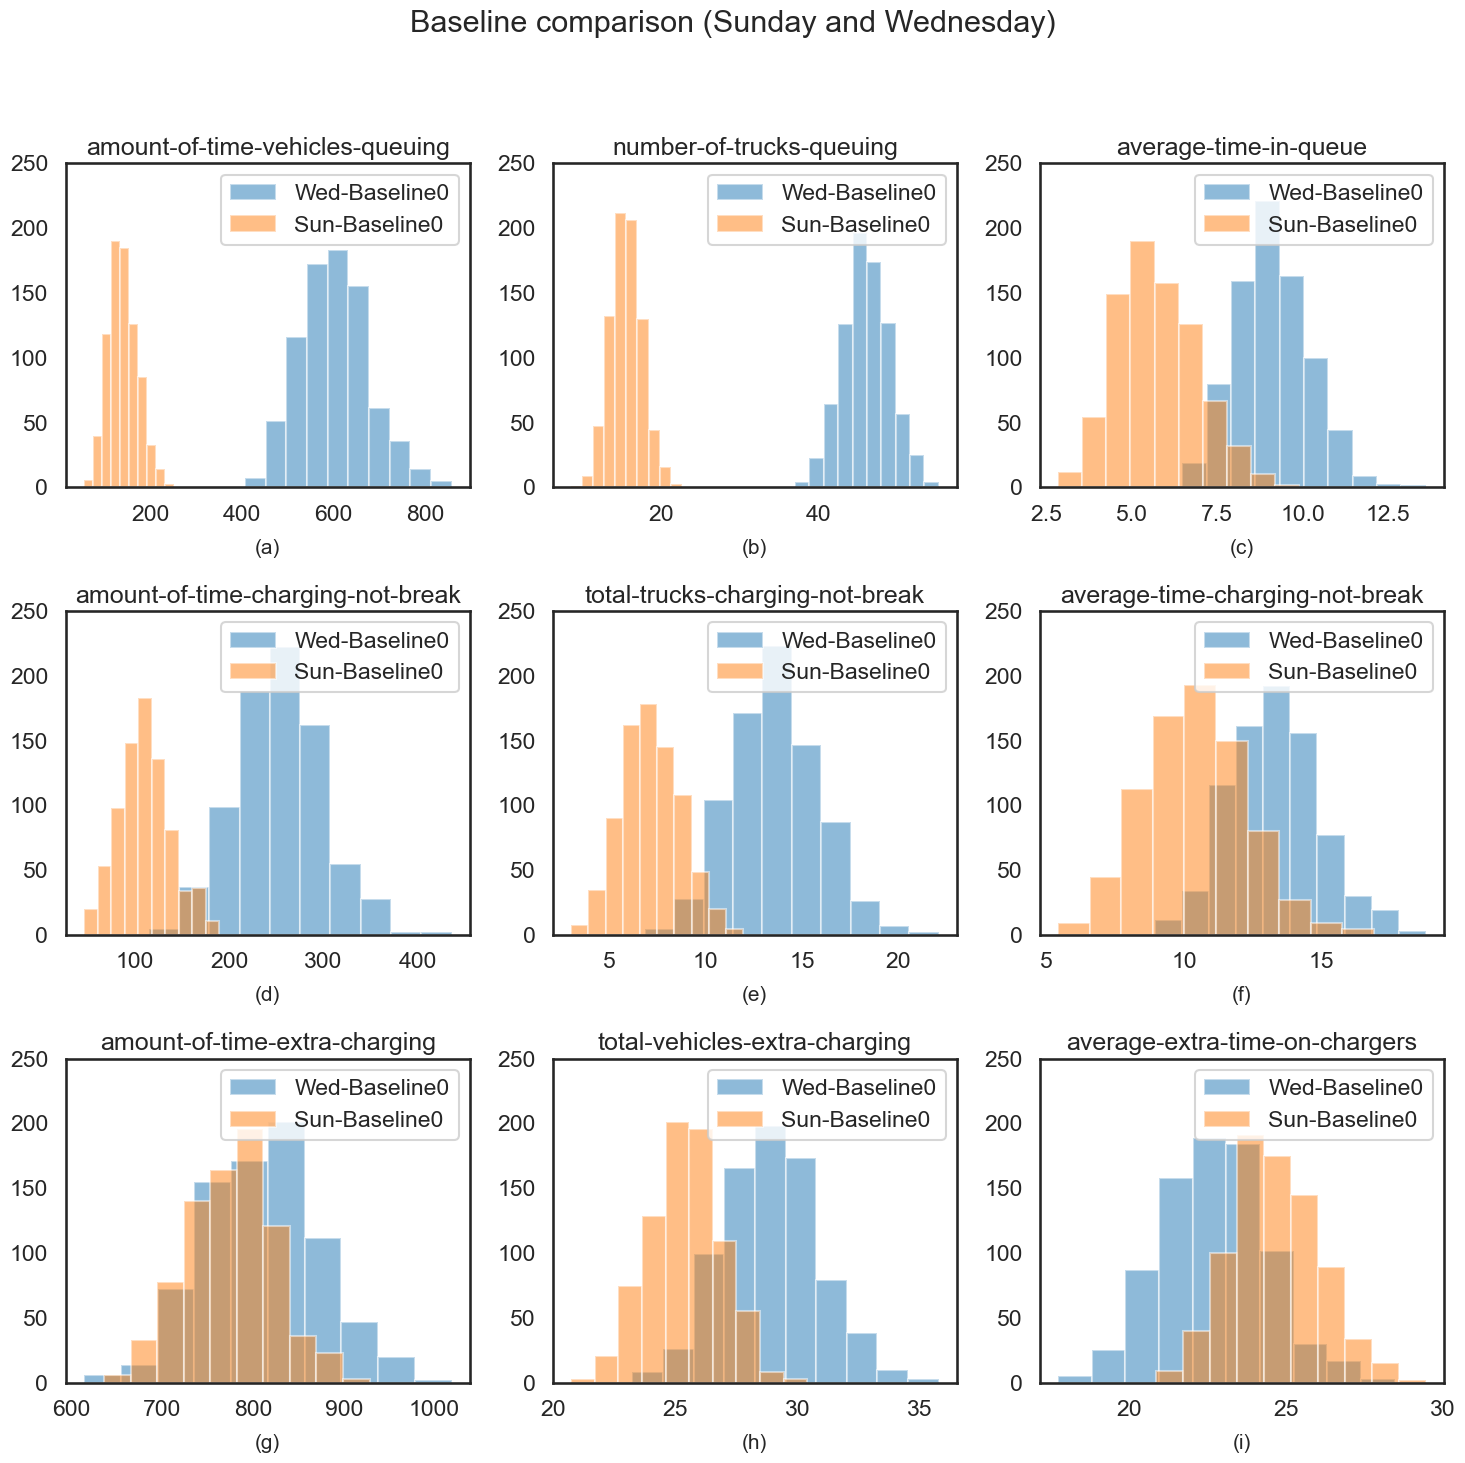

In [32]:
experiments_to_plot = [experiment_results_wed[0], experiment_results_sun[0]]
plot_experiment_parameters(experiments_to_plot, Experiment.report_vars,
                           bins=None, ylim=250,
                           title="Baseline comparison (Sunday and Wednesday)",
                           filename="baseline_comparison.pdf")

### Scenarios 2 and 3 (increase number of chargers) - Wednesday

Plot scenarios 2 and 3 to see how they differ from the baseline

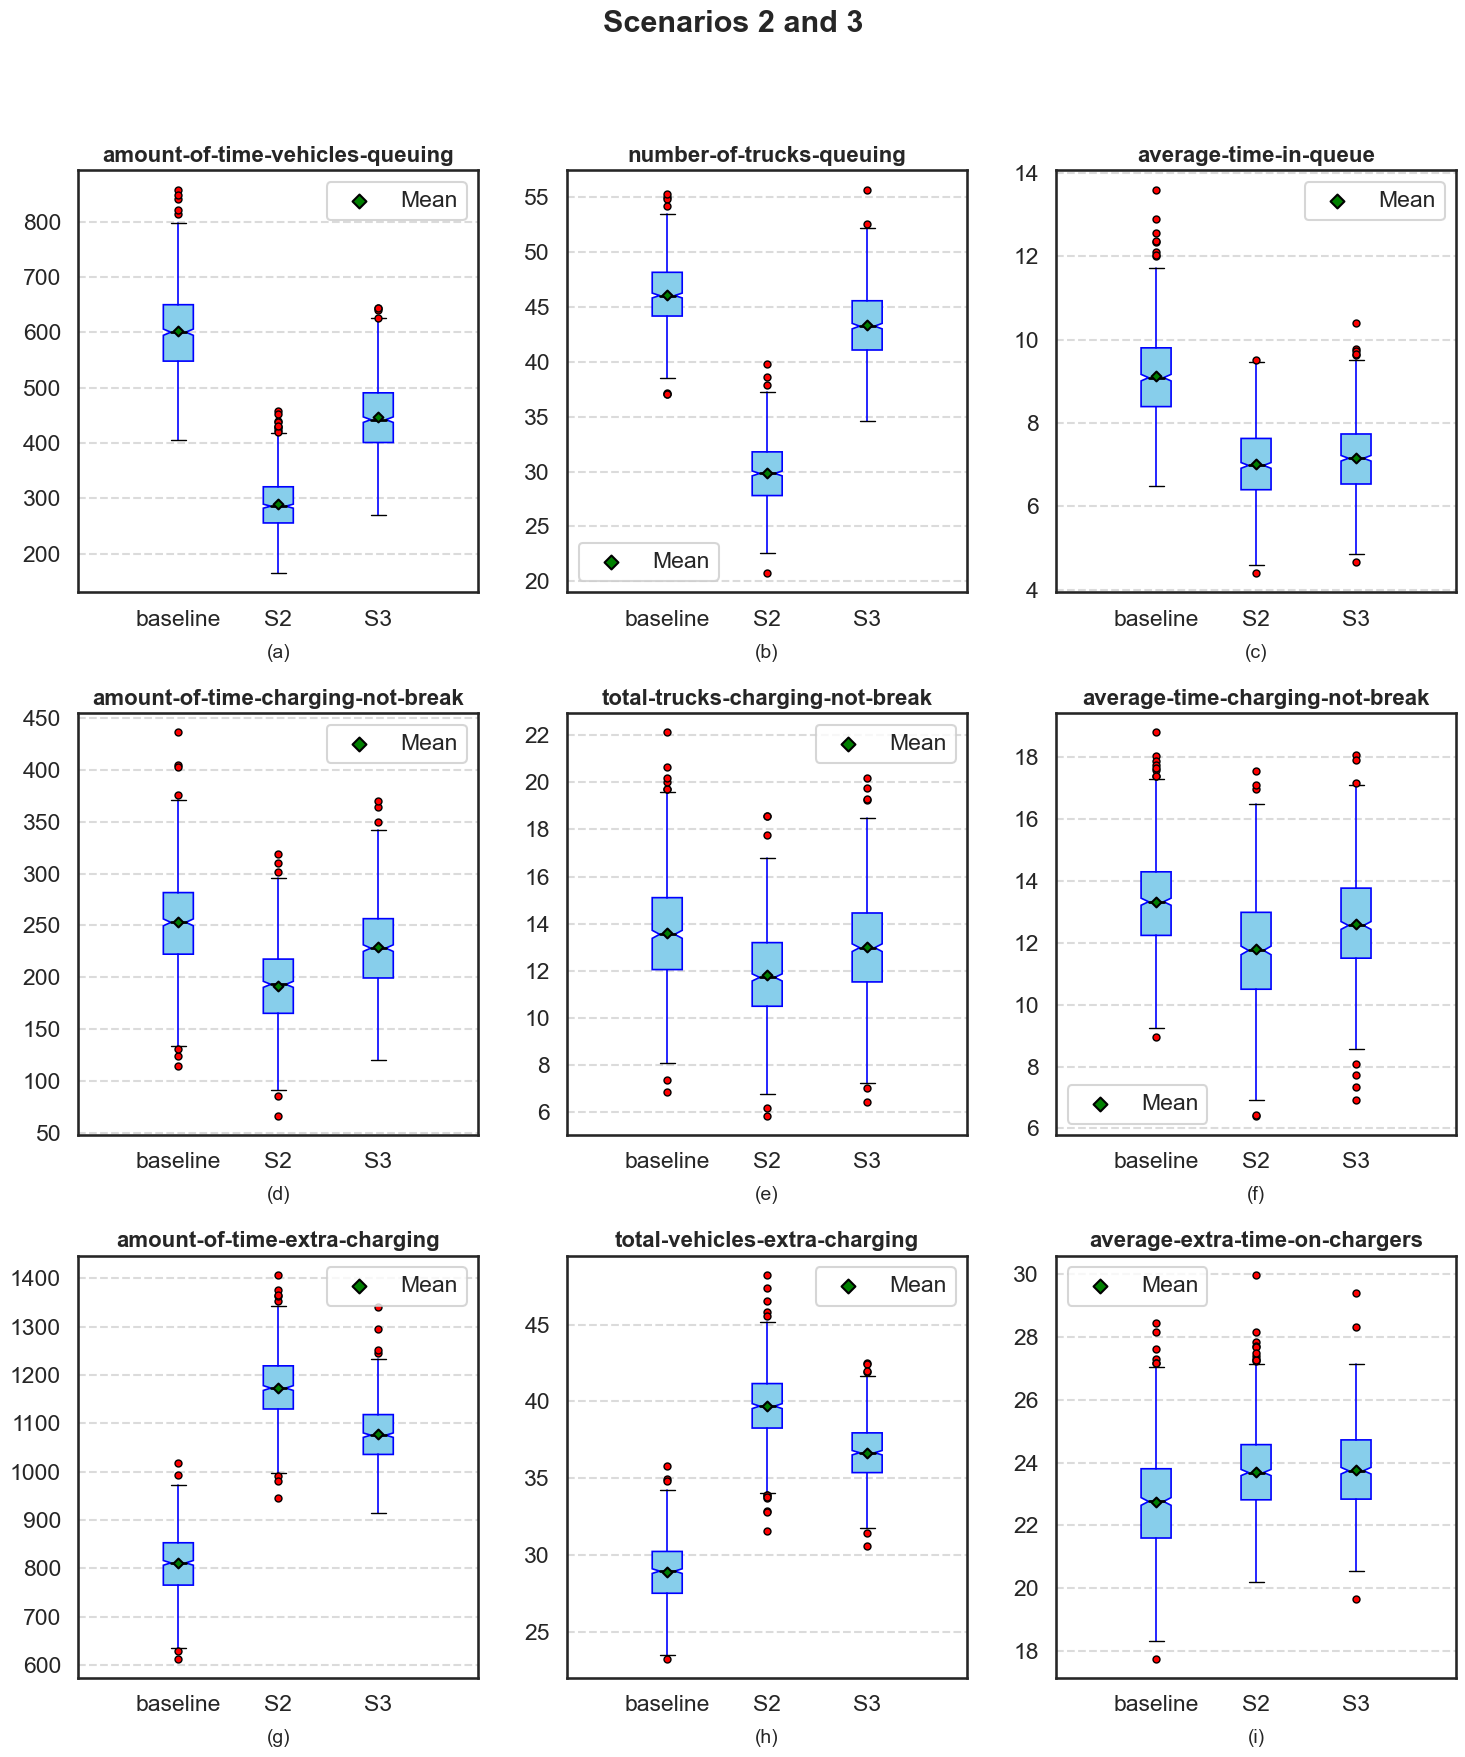

In [33]:
experiments_to_plot = experiment_results_wed[:3]  # Adjust the number of experiments you want to compare
boxplot_experiment_parameters(experiments_to_plot, Experiment.report_vars,
                              categories = ["baseline", "S2","S3"],
                           title="Scenarios 2 and 3",
                           filename="Wed_scenarios_2_3_boxplt.pdf")

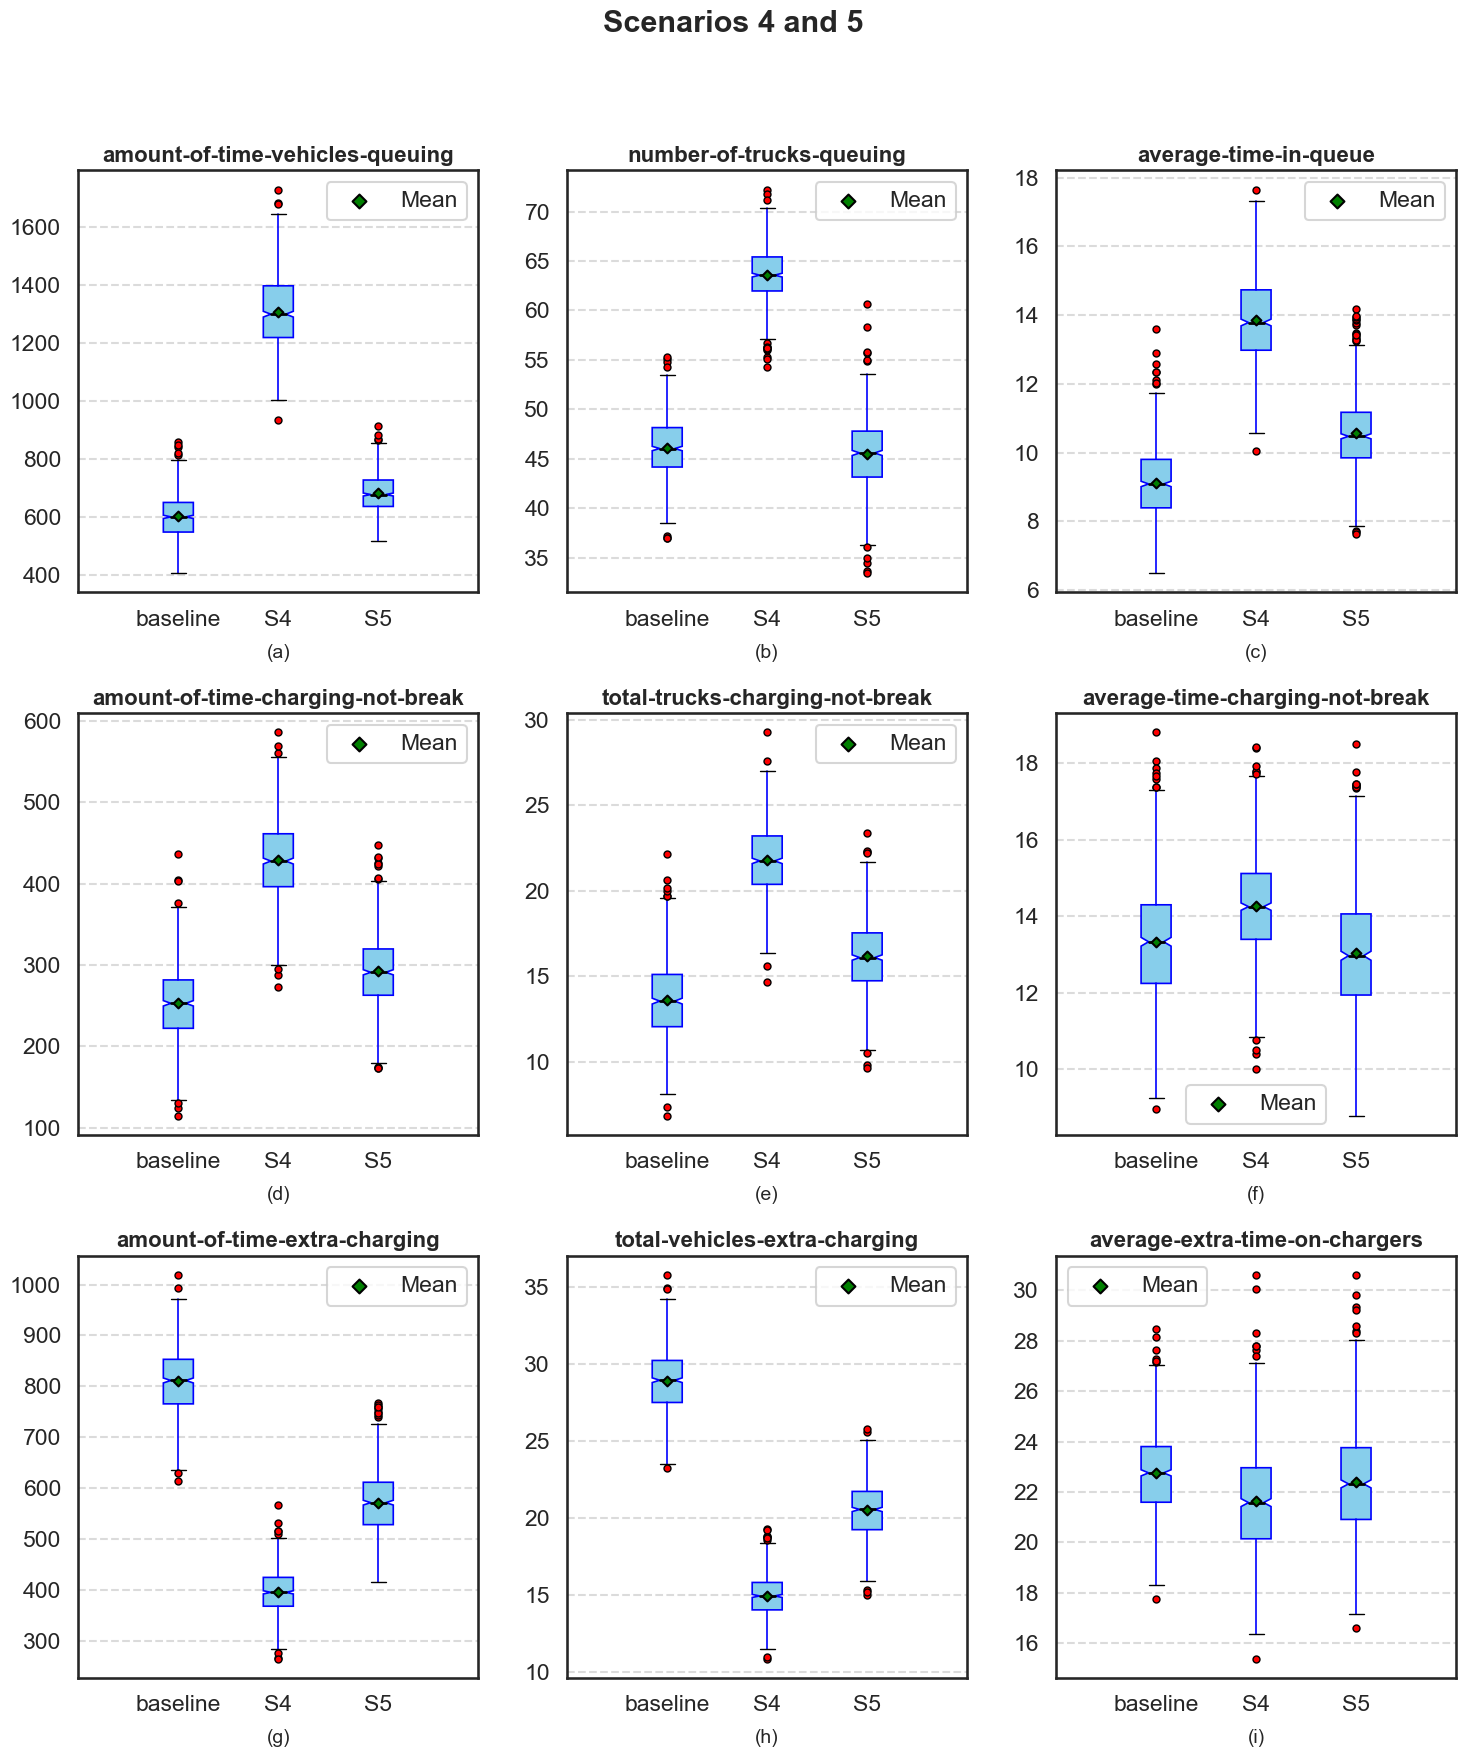

In [34]:
experiments_to_plot = [experiment_results_wed[i] for i in [0, 3, 4]] # Adjust the number of experiments you want to compare
boxplot_experiment_parameters(experiments_to_plot, Experiment.report_vars,
                              categories = ["baseline", "S4","S5"],
                           title="Scenarios 4 and 5",
                           filename="Wed_scenarios_4_5_boxplt.pdf")

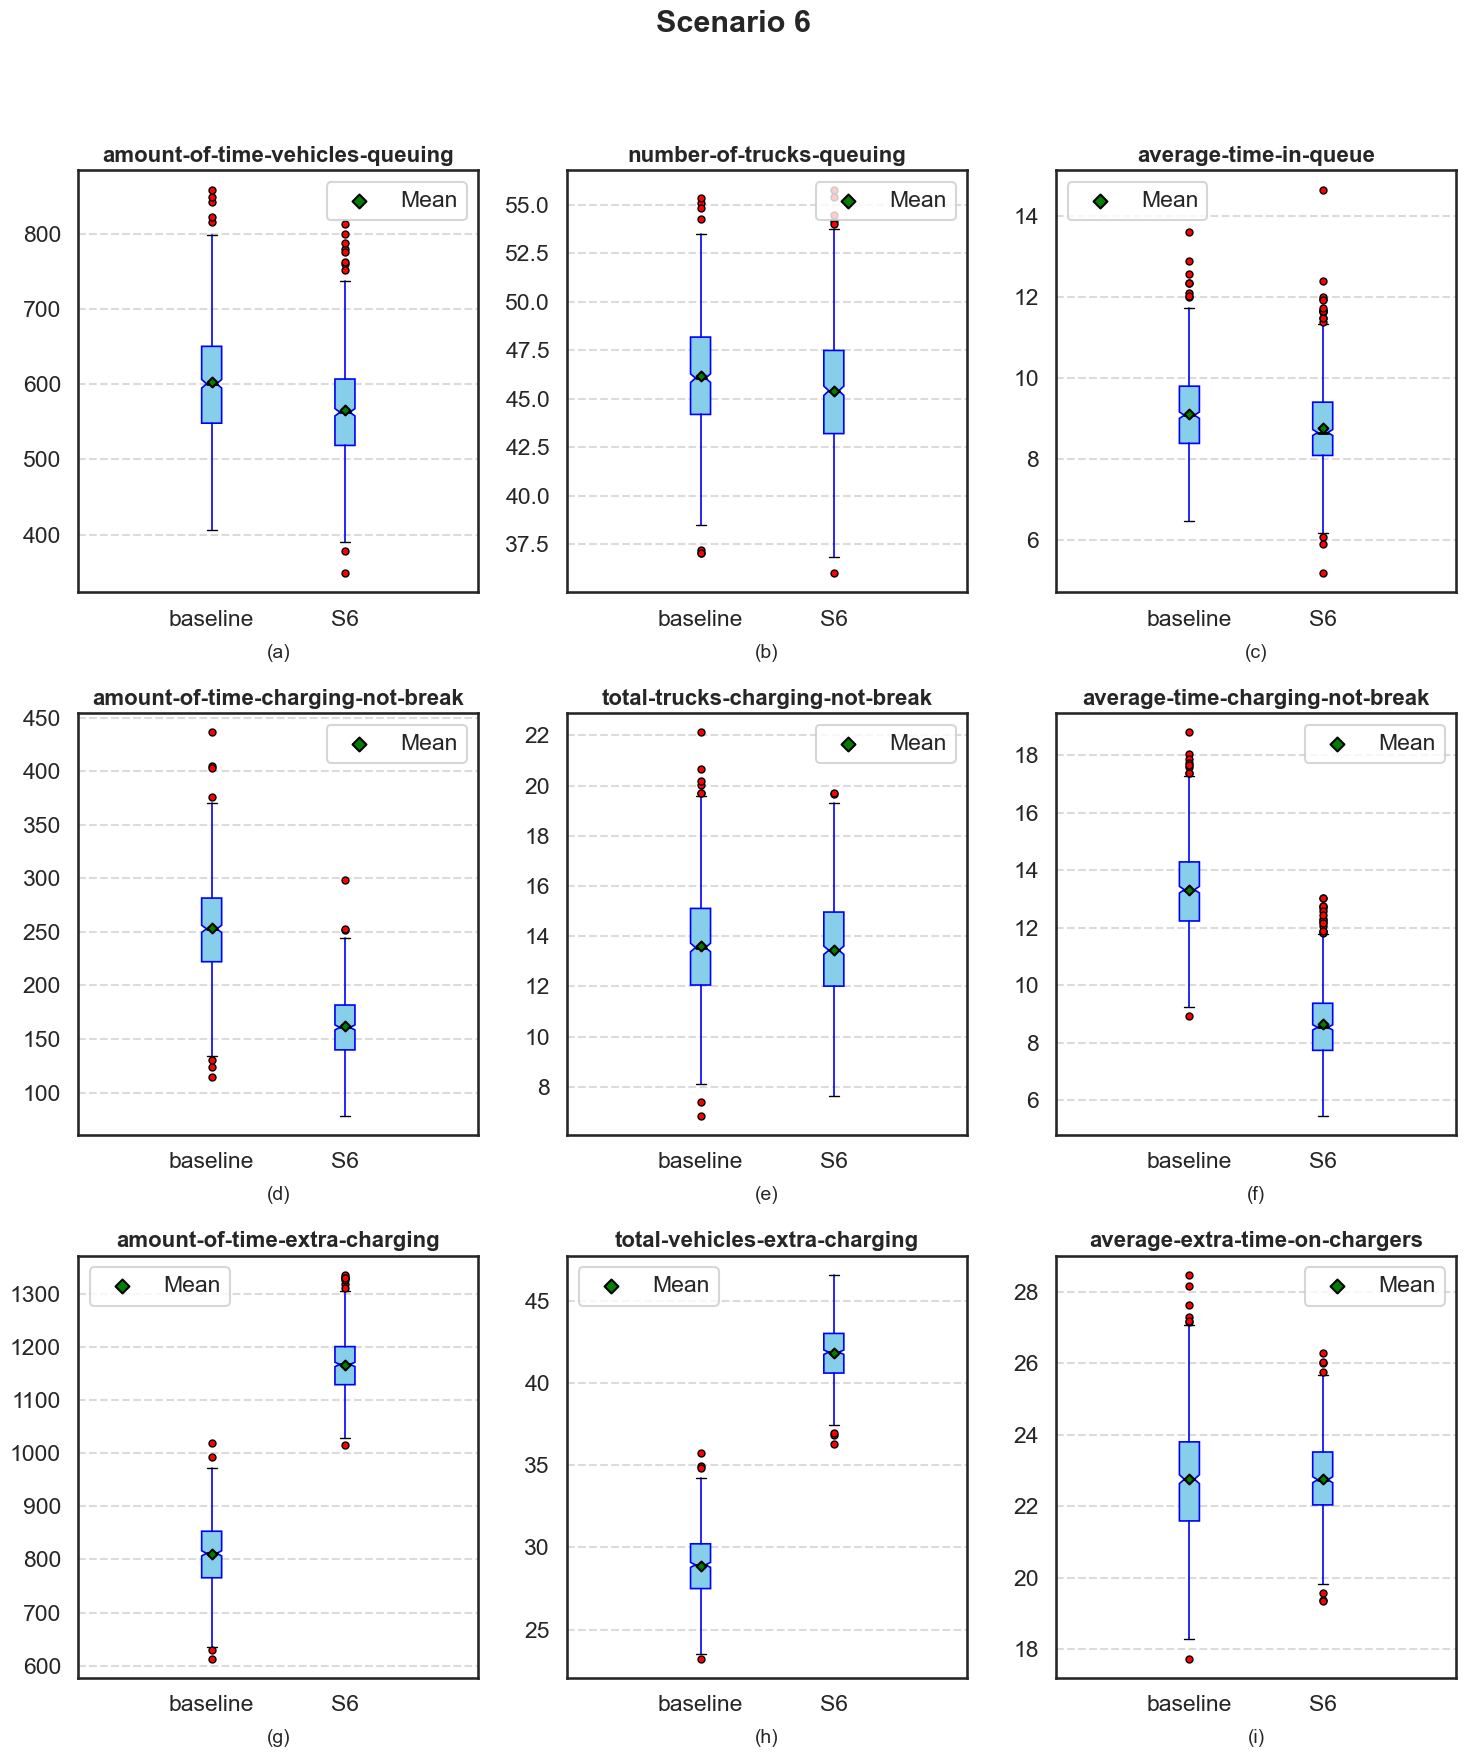

In [35]:
# Select specific experiments (0, 3, 4)
experiments_to_plot = [experiment_results_wed[i] for i in [0, 5]]

# Plot the boxplot for the selected experiments
boxplot_experiment_parameters(experiments_to_plot, Experiment.report_vars,
                              categories = ["baseline", "S6"],
                               title="Scenario 6",
                               filename="Wed_scenario_6_boxplt.pdf")

### Scenarios - Sunday

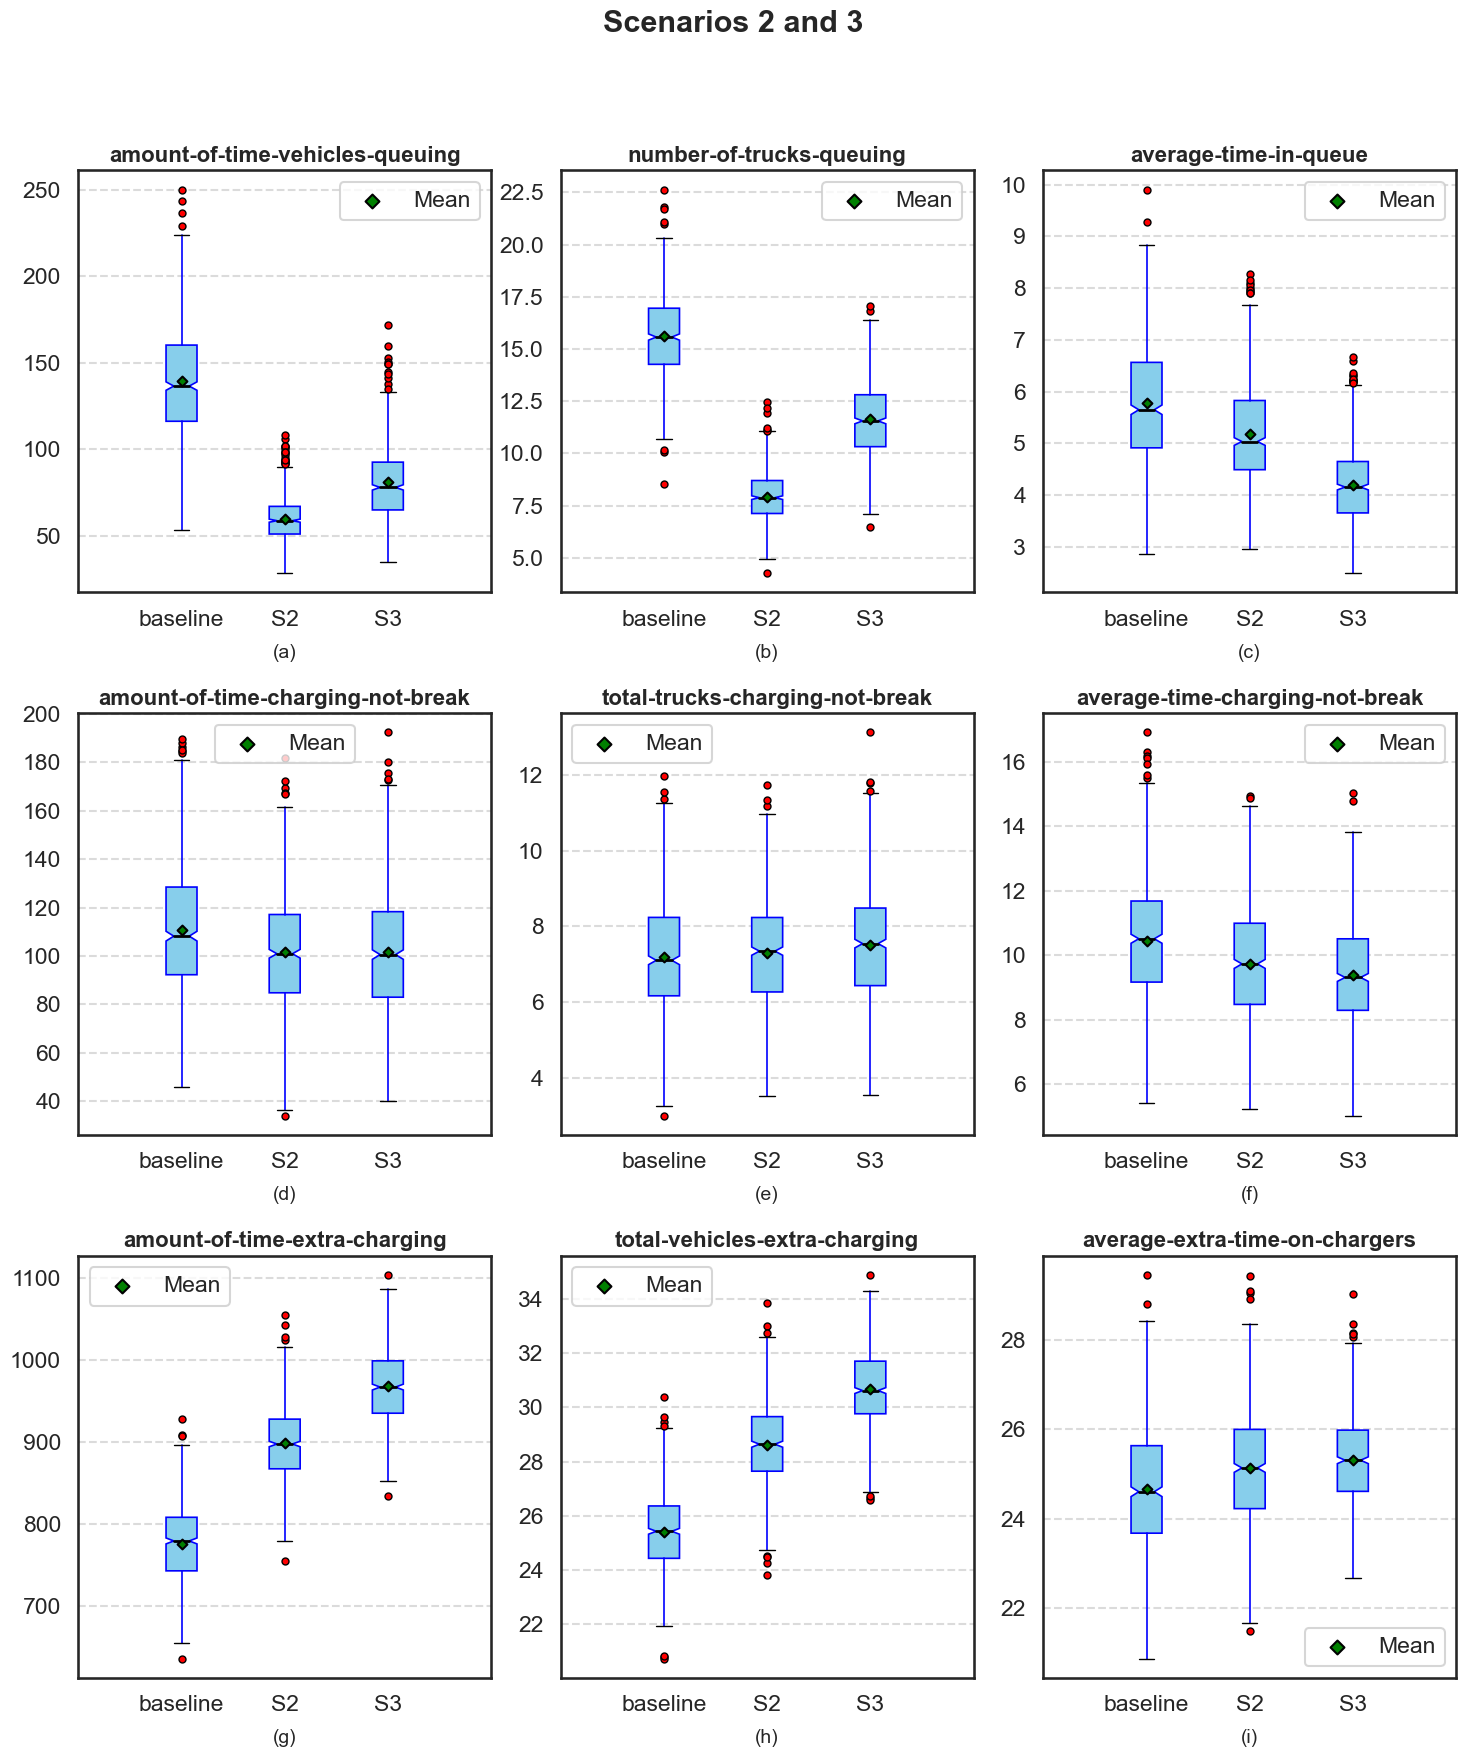

In [36]:
experiments_to_plot = experiment_results_sun[:3]  # Adjust the number of experiments you want to compare
boxplot_experiment_parameters(experiments_to_plot, Experiment.report_vars,
                              categories = ["baseline", "S2","S3"],
                           title="Scenarios 2 and 3",
                           filename="Sun_scenarios_2_3_boxplt.pdf")

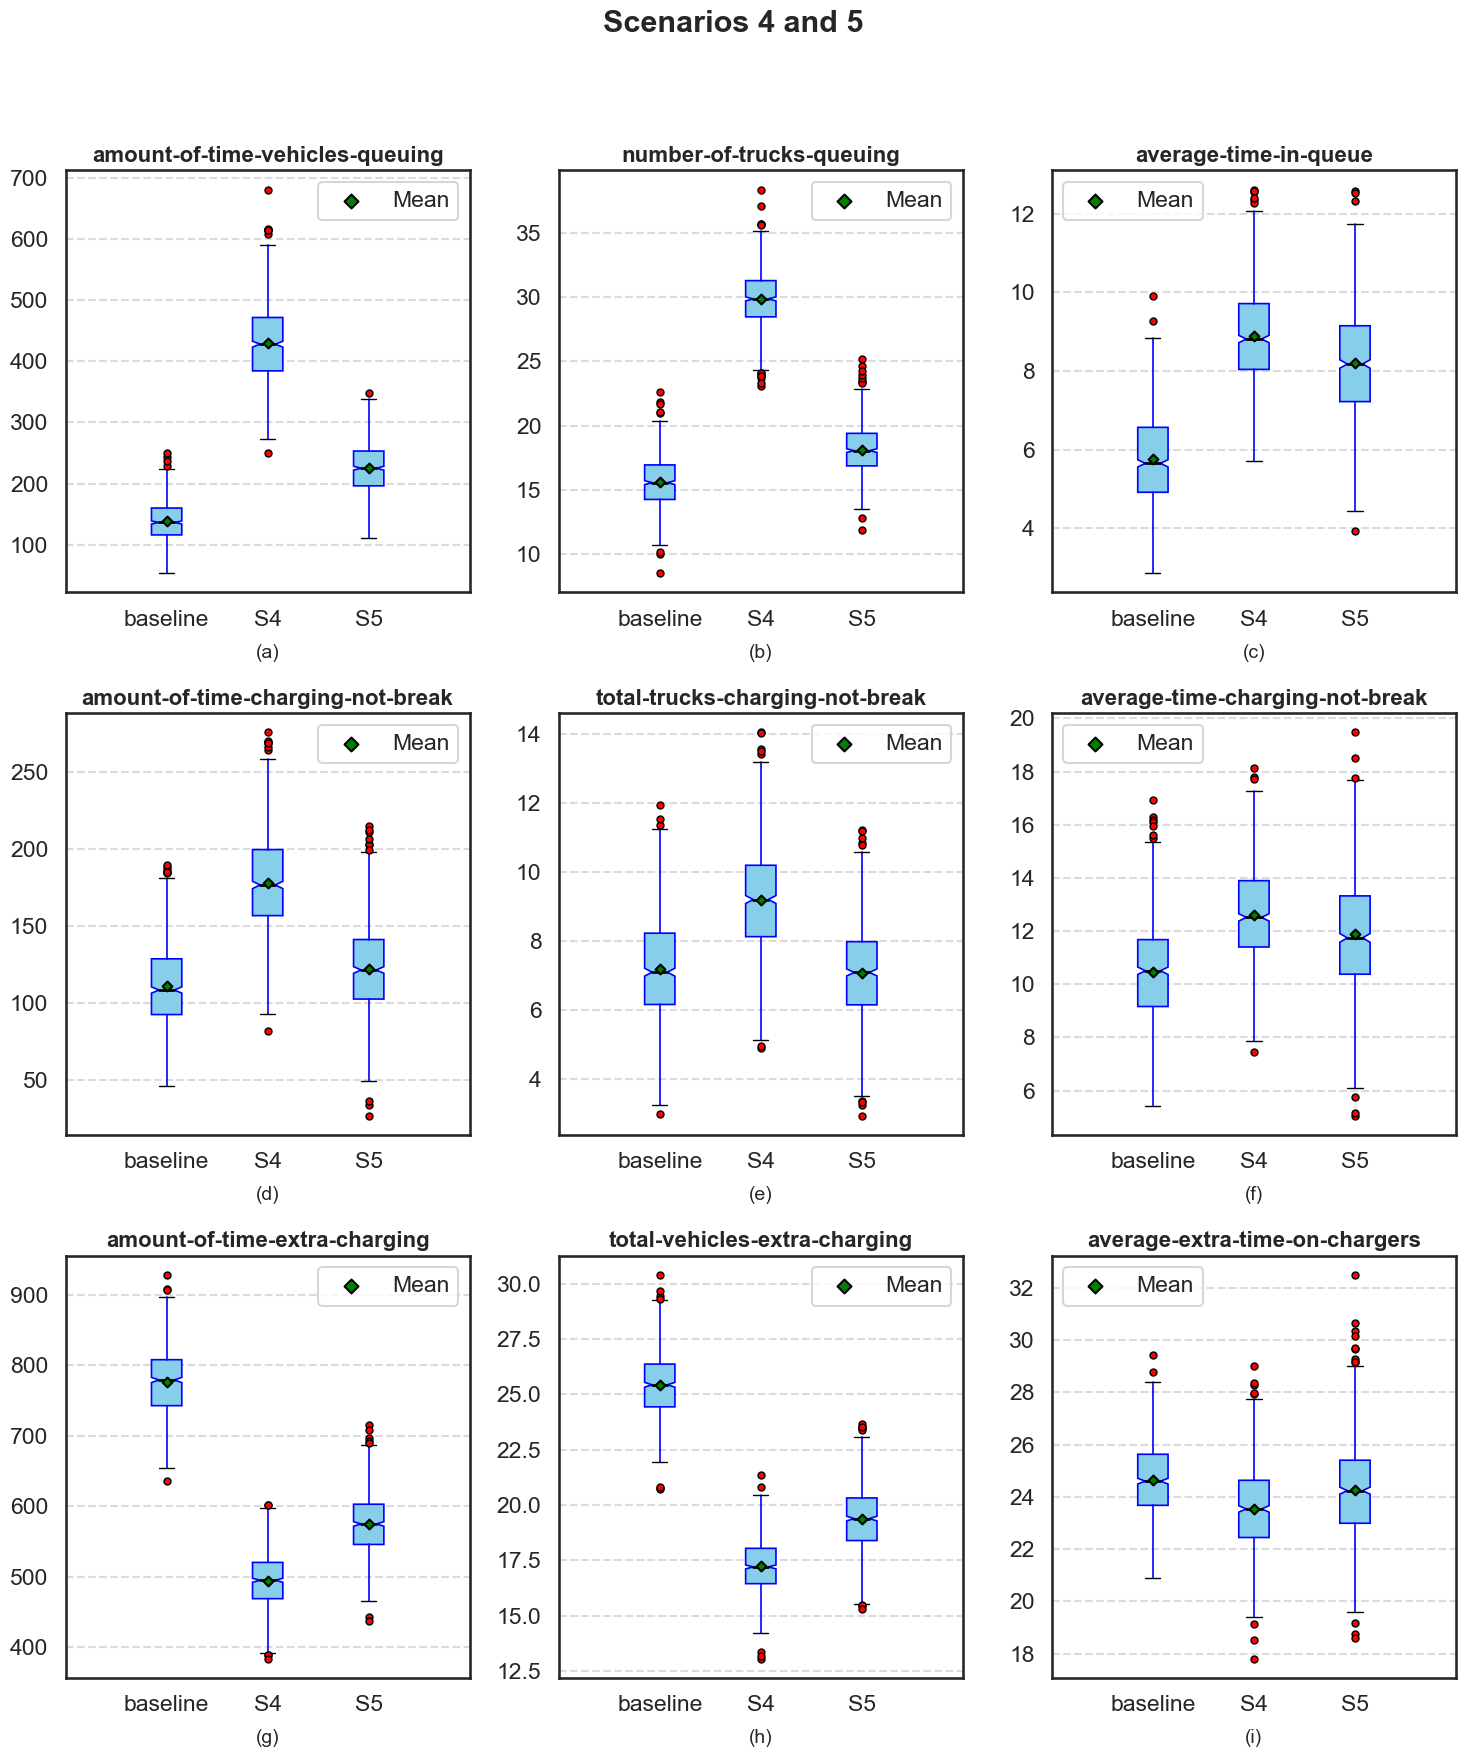

In [37]:
# Select specific experiments (0, 3, 4)
experiments_to_plot = [experiment_results_sun[i] for i in [0, 3, 4]]

# Plot the boxplot for the selected experiments
boxplot_experiment_parameters(experiments_to_plot, Experiment.report_vars,
                              categories = ["baseline", "S4","S5"],
                               title="Scenarios 4 and 5",
                               filename="Sun_scenarios_4_5_boxplt.pdf")

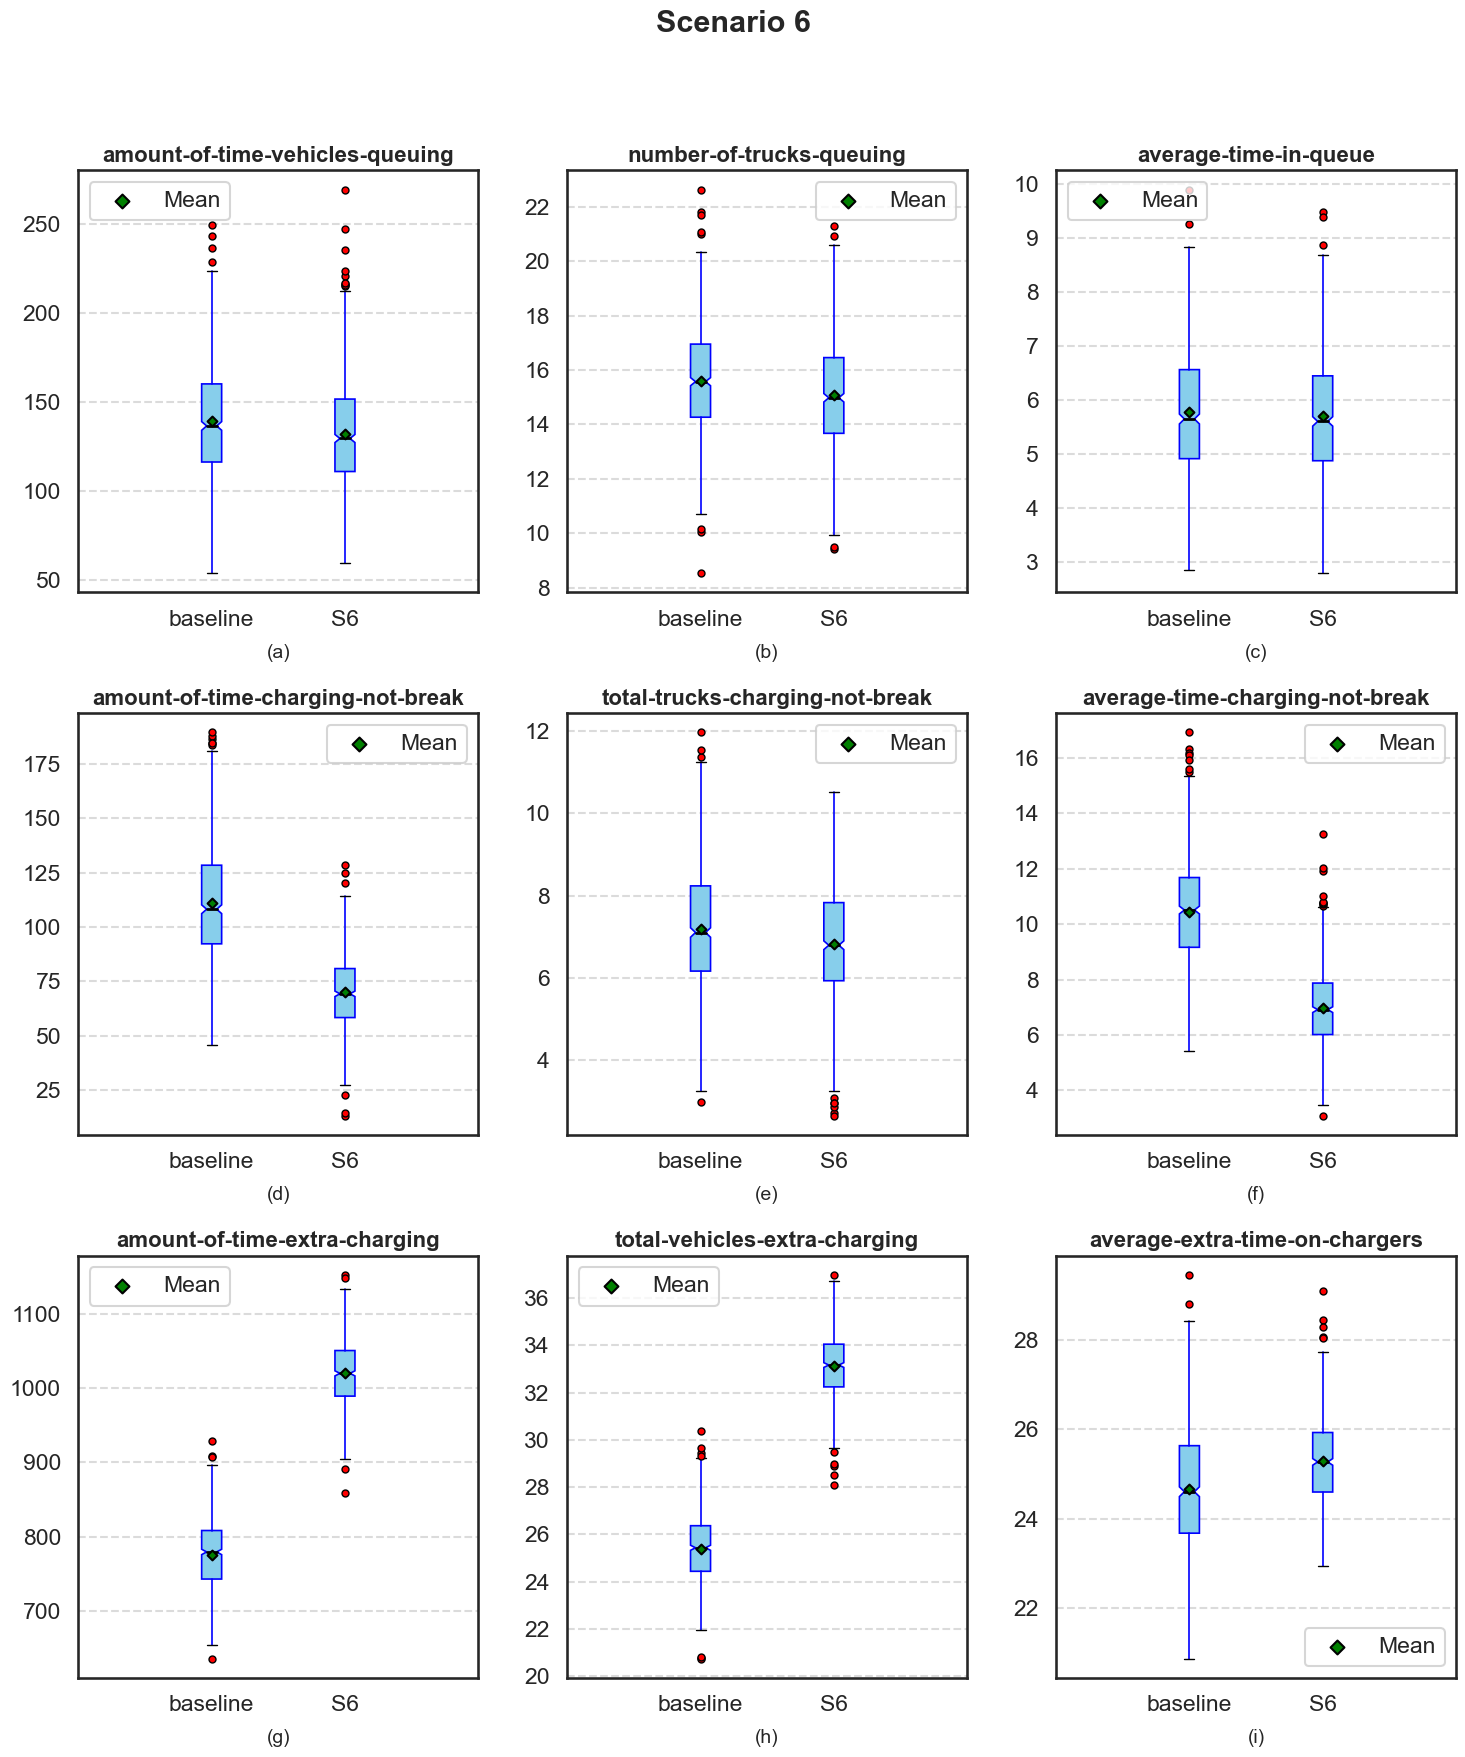

In [38]:
# Select specific experiments (0, 3, 4)
experiments_to_plot = [experiment_results_sun[i] for i in [0, 5]]

# Plot the boxplot for the selected experiments
boxplot_experiment_parameters(experiments_to_plot, Experiment.report_vars,
                              categories = ["baseline", "S6"],
                               title="Scenario 6",
                               filename="Sun_scenarios_6_boxplt.pdf")

### six scenarios (Wednesday)

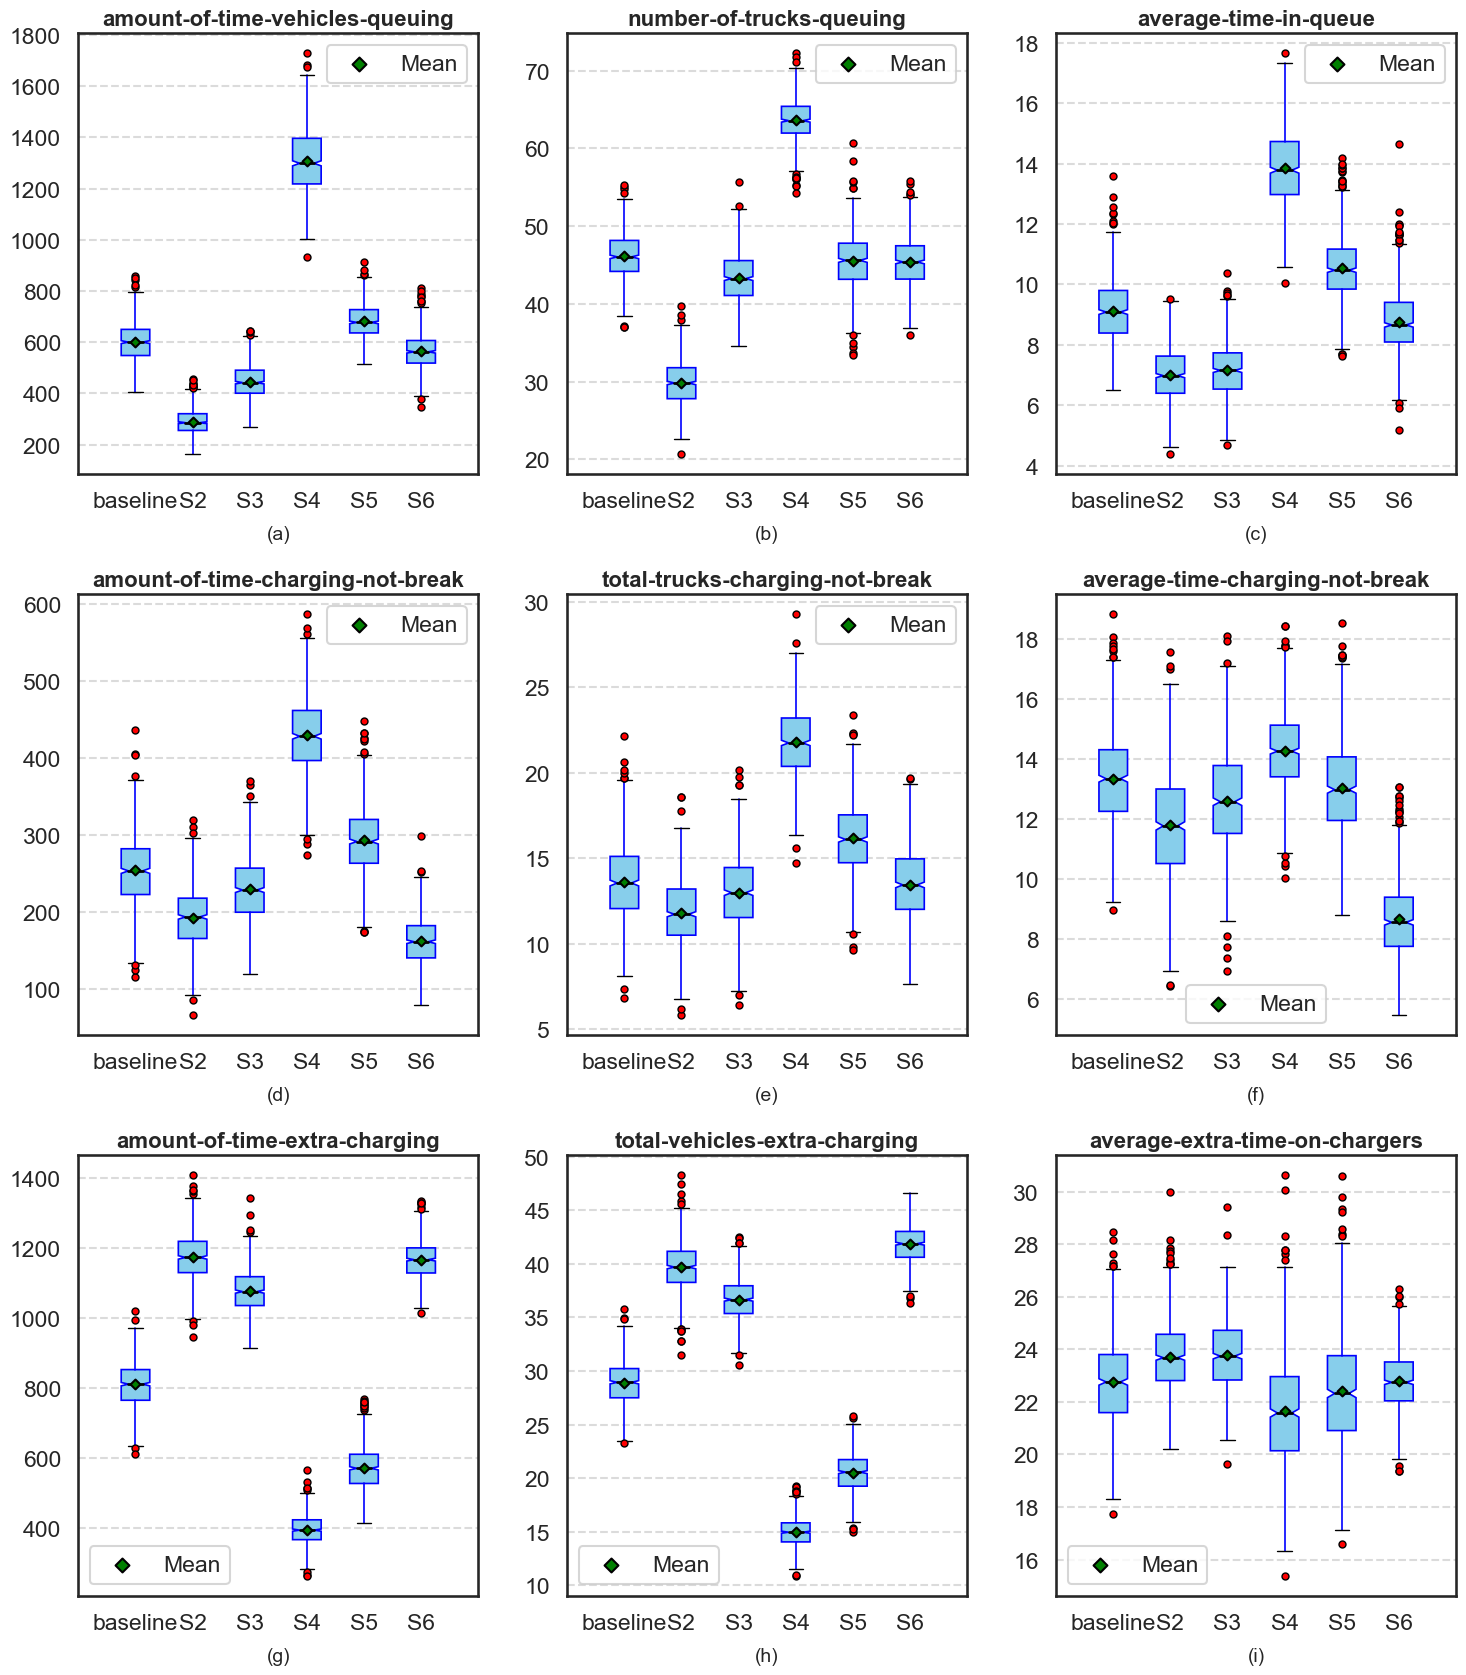

In [39]:
experiments_to_plot = experiment_results_wed[:6]  # Adjust the number of experiments you want to compare
boxplot_experiment_parameters(experiments_to_plot, Experiment.report_vars,
                              categories = ["baseline", "S2","S3","S4","S5","S6"],
                           #title="Scenarios 2 and 3",
                           filename="Wed_six_scenarios_boxplt.pdf")

### six scenarios (Sunday)

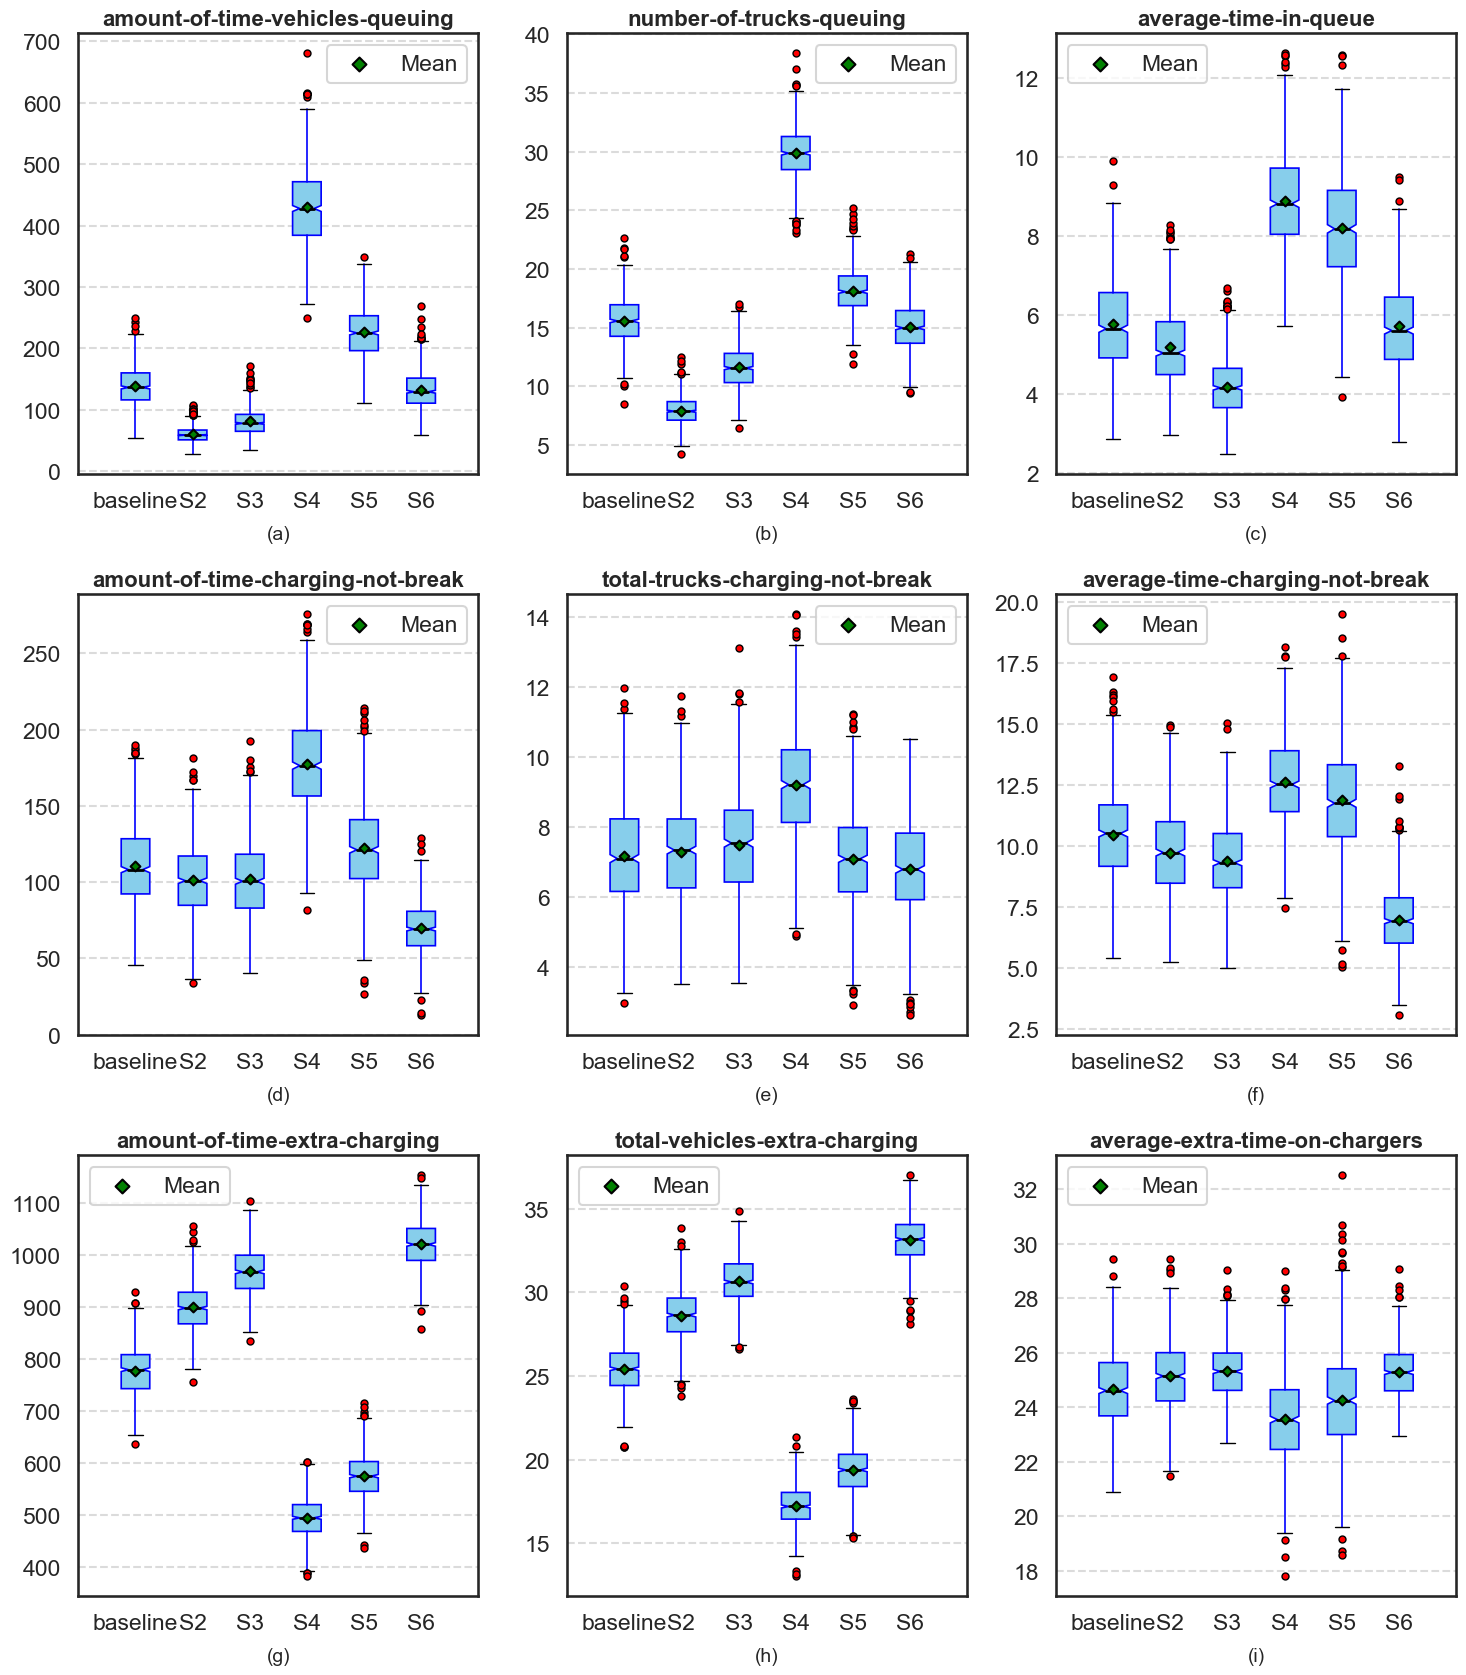

In [40]:
experiments_to_plot = experiment_results_sun[:6]  # Adjust the number of experiments you want to compare
boxplot_experiment_parameters(experiments_to_plot, Experiment.report_vars,
                              categories = ["baseline", "S2","S3","S4","S5","S6"],
                           #title="Scenarios 2 and 3",
                           filename="Sun_six_scenarios_boxplt.pdf")